In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *

/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_3452/4291886752.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


ModuleNotFoundError: No module named 'gseapy'

In [ ]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [ ]:
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
unfilt_ab = od+expand(config['lr']['cerberus']['ab'], species='human')[0] 
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]

ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='human')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='human')[0]

# pp_summary = '../'+expand(config['data']['p_pred']['summary'], species='human')[0]
iq_cerberus_h5 = od+expand(config['lr']['isoquant']['cerberus']['ca_annot'], species='human', obs_col='sample')[0]


iq_gtf = od+expand(config['lr']['isoquant']['gtf'], species='human')[0]
iq_ics = od+expand(config['lr']['isoquant']['cerberus']['ics'], species='human')[0]
iq_ab = od+expand(config['lr']['isoquant']['novel_ab'], species='human')[0]
iq_filt_ab = od+expand(config['lr']['isoquant']['cerberus']['ab'], species='human')[0]

ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'polya'
obs_col = 'sample'
go_gene_subset = 'protein_coding'
predom_iso_subset = 'protein_coding'

m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]

In [ ]:
df = pd.read_csv(filt_ab, sep='\t')
df, tids = get_tpm_table(df, 
                         how='iso',
                         min_tpm=min_tpm,
                         gene_subset='polya')

In [ ]:
df.head()

In [5]:
# get max expression of isoform across libraries
df = df.transpose()
df = df.reset_index(drop=True)
df.rename({'index':'dataset'}, axis=1, inplace=True)
df = df.max(axis=0).to_frame()
df.rename({0:'max_tpm'}, axis=1, inplace=True)
df = df.reset_index()
df.rename({'annot_transcript_id':'tid'}, axis=1, inplace=True)

# get transcript lengths
df2 = pd.read_csv(cerb_t_metadata, sep='\t')
df2 = df2[['tid', 't_len']]
df = df.merge(df2, how='left', on='tid')
df['gid'] = df.tid.str.split('[', expand=True)[0]

In [6]:
# get biotype metadata stuff
df3, _, _ = get_gtf_info(how='gene', add_stable_gid=True, ver='v40_cerberus')
df = df.merge(df3, how='left', left_on='gid', right_on='gid_stable')

In [7]:
# log 2 the tpms
df['log_tpm'] = np.log2(df.max_tpm)

# split by biotype (ie the long ones are probably lncrnas)
# bin by length and do boxplot / violinplot
max_t_len = 15000
bins = [i for i in range(0, max_t_len+1000, 1000)]
bins += [df.t_len.max(axis=0)]
df['len_bin'] = pd.cut(df.t_len, bins)

# make nicer bin names
hr_bin_dict = {}
for b in df.len_bin.unique():
    bmin = int(str(b)[1:].split(',')[0])
    if bmin == max_t_len:
        bmin = str(int(bmin/1000))
        hr_bin_dict[b] = f'{bmin}+'
    else:
        bmin = str(int(bmin/1000))
        bmax = str(int(int(str(b).split(', ')[1][0:-1])/1000))
        hr_bin_dict[b] = f'{bmin}-{bmax}'
           
df['hr_len_bin'] = df['len_bin'].map(hr_bin_dict)

In [8]:
df[['biotype_category', 'tid']].groupby('biotype_category').count()

,tid
biotype_category,
lncRNA,12773
protein_coding,191325
pseudogene,5721


Median max. log2(transcript TPM) for length 3-4: 2.539
Median max. log2(transcript TPM) for length 2-3: 2.616
Median max. log2(transcript TPM) for length 1-2: 2.670
Median max. log2(transcript TPM) for length 4-5: 2.371
Median max. log2(transcript TPM) for length 0-1: 1.769
Median max. log2(transcript TPM) for length 6-7: 2.047
Median max. log2(transcript TPM) for length 5-6: 2.126
Median max. log2(transcript TPM) for length 7-8: 1.979
Median max. log2(transcript TPM) for length 8-9: 1.808
Median max. log2(transcript TPM) for length 15+: 2.331
Median max. log2(transcript TPM) for length 14-15: 2.069
Median max. log2(transcript TPM) for length 10-11: 1.887
Median max. log2(transcript TPM) for length 9-10: 1.764
Median max. log2(transcript TPM) for length 12-13: 1.808
Median max. log2(transcript TPM) for length 11-12: 2.127
Median max. log2(transcript TPM) for length 13-14: 2.135


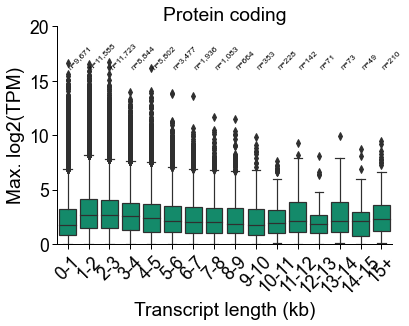

Median max. log2(transcript TPM) for length 1-2: 1.676
Median max. log2(transcript TPM) for length 0-1: 1.109
Median max. log2(transcript TPM) for length 2-3: 2.109
Median max. log2(transcript TPM) for length 3-4: 2.156
Median max. log2(transcript TPM) for length 6-7: 1.126
Median max. log2(transcript TPM) for length 7-8: 0.617
Median max. log2(transcript TPM) for length 5-6: 1.119
Median max. log2(transcript TPM) for length 4-5: 1.551
Median max. log2(transcript TPM) for length 8-9: 1.829
Median max. log2(transcript TPM) for length 9-10: 0.854
Median max. log2(transcript TPM) for length 15+: 2.108


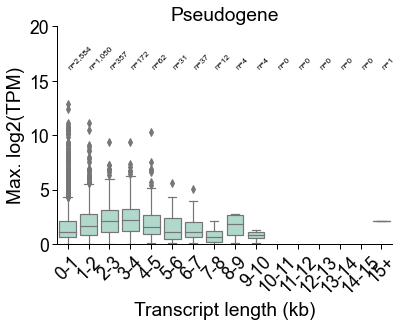

Median max. log2(transcript TPM) for length 0-1: 1.653
Median max. log2(transcript TPM) for length 4-5: 1.540
Median max. log2(transcript TPM) for length 2-3: 2.037
Median max. log2(transcript TPM) for length 3-4: 2.022
Median max. log2(transcript TPM) for length 1-2: 2.093
Median max. log2(transcript TPM) for length 5-6: 1.279
Median max. log2(transcript TPM) for length 15+: 2.690
Median max. log2(transcript TPM) for length 6-7: 1.874
Median max. log2(transcript TPM) for length 7-8: 2.206
Median max. log2(transcript TPM) for length 8-9: 2.527
Median max. log2(transcript TPM) for length 10-11: 3.097
Median max. log2(transcript TPM) for length 13-14: 3.534
Median max. log2(transcript TPM) for length 12-13: 2.118
Median max. log2(transcript TPM) for length 9-10: 1.101
Median max. log2(transcript TPM) for length 11-12: 1.105
Median max. log2(transcript TPM) for length 14-15: 3.032


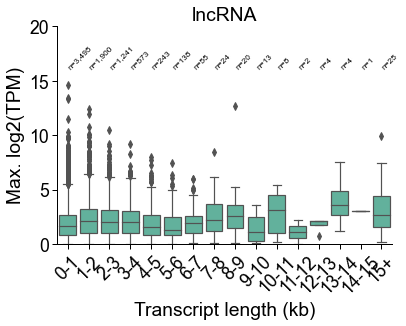

In [9]:
sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

ic_colors, order = get_ic_nov_colors()
c = ic_colors['Known']
m = {'protein_coding': 'Protein coding',
     'lncRNA': 'lncRNA', 'pseudogene': 'Pseudogene'}
cats = ['Protein coding', 'lncRNA', 'Pseudogene']
c_dict, order = get_shade_colors(c, cats)
df['gene_subset_2'] = df.biotype_category.map(m)
df['gene_subset_2'] = df['gene_subset_2'].astype('category')
df['gene_subset_2'] = df['gene_subset_2'].cat.reorder_categories(cats, ordered=True)
for c in df.gene_subset_2.unique().tolist():
    temp = df.loc[df.gene_subset_2==c].copy(deep=True)
    ax = sns.boxplot(temp, x='hr_len_bin', y='log_tpm', color=c_dict[c])
    ax.tick_params(axis='x', rotation=45)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set(title=c, xlabel='Transcript length (kb)', ylabel='Max. log2(TPM)',
           ylim=(0,20))
    
    # what's the median tpm for each thing?
    for i in temp.hr_len_bin.unique().tolist():
        med = temp.loc[temp.hr_len_bin==i, 'log_tpm'].median(axis=0)
        print(f'Median max. log2(transcript TPM) for length {i}: {med:.3f}')
    
    # https://stackoverflow.com/questions/63872880/add-number-of-observations-to-horizontal-boxplot-seaborn
    nobs = temp[['hr_len_bin', 'gid_stable']].groupby('hr_len_bin').nunique().reset_index()
    nobs = [str(x) for x in nobs.gid_stable.tolist()]
    nobs = ['n=' + '{:,}'.format(int(i)) for i in nobs] 
    pos = range(len(nobs))
    for tick,label in zip(pos,ax.get_xticklabels()):
        ax.text(tick,16,nobs[tick],color='black', verticalalignment = "bottom", rotation=45,fontsize='small')
        
    sns.despine()
    
    fname = f'figures/transcript_len_vs_exp_{c.replace(" ", "_")}.pdf'
    plt.savefig(fname, dpi=500)
    
    plt.show()
    

In [10]:
df.loc[(df.hr_len_bin=='15+')&(df.gene_subset_2=='Pseudogene')]

,tid,max_tpm,t_len,gid_x,gid_y,gname,length,biotype,biotype_category,tf,MANE_Select,MANE_Plus_Clinical,gid_stable,log_tpm,len_bin,hr_len_bin,gene_subset_2
160260,"ENSG00000180438[4,10,5]",4.309988,17436,ENSG00000180438,ENSG00000180438.15,TPRXL,145639,transcribed_processed_pseudogene,pseudogene,False,False,False,ENSG00000180438,2.107684,"(15000, 213793]",15+,Pseudogene


In [11]:
# how long are predomiant isoforms? how often are they ISM isoforms? how much shorter are they than the known isoforms of a gene?
df = pd.read_csv(pi_tpm_table, sep='\t')

# # get only predominant
# df = df.loc[df.triplet_rank==1]
# df.head()

In [12]:
# get transcript lengths
df2 = pd.read_csv(cerb_t_metadata, sep='\t')
df2 = df2[['tid', 't_len']]
df = df.merge(df2, how='left', on='tid')

In [13]:
# get biotype metadata stuff
df3, _, _ = get_gtf_info(how='gene', add_stable_gid=True, ver='v40_cerberus')
df = df.merge(df3, how='left', left_on='gid', right_on='gid_stable')

In [14]:
# limit to polya genes
cats = get_polya_cats()
df = df.loc[df.biotype_category.isin(cats)]
df.head()

,tid,sample,triplet_tpm,triplet_pi,gid_x,gname_x,triplet_rank,t_len,gid_y,gname_y,length,biotype,biotype_category,tf,MANE_Select,MANE_Plus_Clinical,gid_stable
1891,"ENSG00000285988[1,2,2]",pc9,2.074560,45.454548,ENSG00000285988,ENSG00000285988,1,3096,ENSG00000285988.1,ENSG00000285988,103395.0,lncRNA,lncRNA,False,False,False,ENSG00000285988
1892,"ENSG00000285988[1,1,2]",pc9,1.675734,36.363636,ENSG00000285988,ENSG00000285988,2,2912,ENSG00000285988.1,ENSG00000285988,103395.0,lncRNA,lncRNA,False,False,False,ENSG00000285988
1893,"ENSG00000285988[1,1,1]",pc9,0.845911,18.181818,ENSG00000285988,ENSG00000285988,3,718,ENSG00000285988.1,ENSG00000285988,103395.0,lncRNA,lncRNA,False,False,False,ENSG00000285988
1894,"ENSG00000285988[1,2,2]",mcf10a,1.064827,100.000000,ENSG00000285988,ENSG00000285988,1,3096,ENSG00000285988.1,ENSG00000285988,103395.0,lncRNA,lncRNA,False,False,False,ENSG00000285988
1895,"ENSG00000285988[1,2,2]",calu3,3.561985,72.727270,ENSG00000285988,ENSG00000285988,1,3096,ENSG00000285988.1,ENSG00000285988,103395.0,lncRNA,lncRNA,False,False,False,ENSG00000285988


In [15]:
print(len(df.index))
df = df[['tid', 't_len', 'triplet_rank', 'biotype_category']].drop_duplicates()
print(len(df.index))

3558738
1139286


In [16]:
sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

max_rank = 10

ic_colors, order = get_ic_nov_colors()
c = ic_colors['Known']
m = {'protein_coding': 'Protein coding',
     'lncRNA': 'lncRNA', 'pseudogene': 'Pseudogene'}
cats = ['Protein coding', 'lncRNA', 'Pseudogene']
c_dict, order = get_shade_colors(c, cats)
df['gene_subset_2'] = df.biotype_category.map(m)
df['gene_subset_2'] = df['gene_subset_2'].astype('category')
df['gene_subset_2'] = df['gene_subset_2'].cat.reorder_categories(cats, ordered=True)

for c in df.gene_subset_2.unique().tolist():
    print(c)
    temp = df.loc[df.gene_subset_2==c].copy(deep=True)

    # distribution of lengths of transcripts at different ranks; again split by biotype
    temp = temp.loc[temp.triplet_rank <= max_rank].copy(deep=True)
    
    # what's the median length for each thing?
    for i in temp.triplet_rank.unique().tolist():
        med = temp.loc[temp.triplet_rank==i, 't_len'].median(axis=0)
        print(f'Median transcript length for rank {i}: {med}')
        
    # what's the median length for each thing?
    for i in temp.triplet_rank.unique().tolist():
        med = temp.loc[temp.triplet_rank==i, 't_len'].mean(axis=0)
        print(f'Mean transcript length for rank {i}: {med}')
    
    
    ax = sns.boxplot(temp, x='triplet_rank', y='t_len', color=c_dict[c])
    if c== 'Protein coding':
        ymax = 1000000
        txt = 340000
    else:
        ymax = 100000
        txt = 23000
    ax.set(ylim=(100,ymax), ylabel='Transcript length',
           xlabel='Transcript rank', alpha=1, title=c,yscale='log')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # https://stackoverflow.com/questions/63872880/add-number-of-observations-to-horizontal-boxplot-seaborn
    nobs = temp[['triplet_rank', 'tid']].groupby('triplet_rank').nunique().reset_index()
    nobs = [str(x) for x in nobs.tid.tolist()]
    nobs = ['n=' + '{:,}'.format(int(i)) for i in nobs] 
    pos = range(len(nobs))
    for tick,label in zip(pos,ax.get_xticklabels()):
        ax.text(tick,txt,nobs[tick],color='black', verticalalignment = "bottom", rotation=45,fontsize='small')
        
    
    # plt.show()
    # print()
    
    fname = f'figures/transcript_len_vs_rank_{c.replace(" ", "_")}.pdf'
    plt.savefig(fname, dpi=500)
    plt.clf()
    print()

lncRNA
Median transcript length for rank 1: 1057.5
Median transcript length for rank 2: 1367.0
Median transcript length for rank 3: 1519.0
Median transcript length for rank 4: 1604.0
Median transcript length for rank 5: 1665.0
Median transcript length for rank 6: 1745.5
Median transcript length for rank 7: 1802.0
Median transcript length for rank 8: 1792.0
Median transcript length for rank 9: 1837.0
Median transcript length for rank 10: 1794.0
Mean transcript length for rank 1: 1603.122697563874
Mean transcript length for rank 2: 1854.534904805077
Mean transcript length for rank 3: 1969.4568336269822
Mean transcript length for rank 4: 2084.2066555740435
Mean transcript length for rank 5: 2054.949116904962
Mean transcript length for rank 6: 2115.6739130434785
Mean transcript length for rank 7: 2170.7571614583335
Mean transcript length for rank 8: 2153.75845790716
Mean transcript length for rank 9: 2233.678942398489
Mean transcript length for rank 10: 2119.1040268456377

Protein coding
M

<Figure size 432x288 with 0 Axes>

In [17]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
moore = sm.datasets.get_rdataset("Moore", "carData",
                                  cache=True) # load data
print(moore.__doc__)

===== ===============
Moore R Documentation
===== ===============

Status, Authoritarianism, and Conformity
----------------------------------------

Description
~~~~~~~~~~~

The ``Moore`` data frame has 45 rows and 4 columns. The data are for
subjects in a social-psychological experiment, who were faced with
manipulated disagreement from a partner of either of low or high status.
The subjects could either conform to the partner's judgment or stick
with their own judgment.

Usage
~~~~~

::

   Moore

Format
~~~~~~

This data frame contains the following columns:

partner.status
   Partner's status. A factor with levels: ``high``, ``low``.

conformity
   Number of conforming responses in 40 critical trials.

fcategory
   F-Scale Categorized. A factor with levels (note levels out of order):
   ``high``, ``low``, ``medium``.

fscore
   Authoritarianism: F-Scale score.

Source
~~~~~~

Moore, J. C., Jr. and Krupat, E. (1971) Relationship between source
status, authoritarianism and conformit

In [94]:
# do anova test
import statsmodels.api as sm
from statsmodels.formula.api import ols

temp = df.loc[df.gene_subset_2==c].copy(deep=True)
temp = temp.loc[temp.triplet_rank <= max_rank].copy(deep=True)
thing = ols('t_len ~ triplet_rank',
                 data=temp).fit()
table = sm.stats.anova_lm(thing, typ=2)
print(table)

                    sum_sq       df            F  PR(>F)
triplet_rank  3.002496e+09      1.0  2036.581255     0.0
Residual      2.116774e+10  14358.0          NaN     NaN


In [72]:
# what's the median length for each thing all together?
temp = df.loc[df.triplet_rank <= max_rank].copy(deep=True) 
for i in temp.triplet_rank.unique().tolist():
    med = temp.loc[temp.triplet_rank==i, 't_len'].median(axis=0)
    print(f'Median transcript length for rank {i}: {med}')

Median transcript length for rank 1: 2176.0
Median transcript length for rank 2: 2409.0
Median transcript length for rank 3: 2431.0
Median transcript length for rank 4: 2445.0
Median transcript length for rank 5: 2442.0
Median transcript length for rank 6: 2447.0
Median transcript length for rank 7: 2448.0
Median transcript length for rank 8: 2459.0
Median transcript length for rank 9: 2468.0
Median transcript length for rank 10: 2480.0


In [147]:
# # # perform a wilcoxon rank sum test between most highly expressed (rank 1, predominant)
# # # and the rest
# # from statsmodels.stats.multitest import multipletests

# st_df = pd.DataFrame()
# for i in temp.triplet_rank.unique().tolist():
#     if i == 1:
#         continue
#     x = temp.loc[temp.triplet_rank==1, 't_len'].tolist()
#     y = temp.loc[temp.triplet_rank==i, 't_len'].tolist()
#     statistic, pval = st.ranksums(x, y)
#     # print(f'Rank 1 vs. rank {i}')
#     # print(f'Wilcoxon rank-sum stat: {statistic}, pval: {pval}')
#     # print()
#     data = [len(x), len(y), statistic, pval, i]
#     cols = ['n_x', 'n_y', 'statistic', 'pval', 'triplet_rank']
#     temp2 = pd.DataFrame(data=[data], columns=cols)
#     st_df = pd.concat([st_df, temp2], axis=0) 

# # # FDR correction
# # _, adj_p_vals, _, _ = multipletests(st_df.pval.tolist(), method='fdr_bh')
# # st_df['adj_pval'] = adj_p_vals
# # st_df